# Analysing our Graph

With the equities data loaded into our graph structure and Neo4j, we can perform some basic analysis to acquaint ourselves with the data and how the model will work.

In [1]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os
import logging

# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

load_dotenv()

THRESHOLD = float(os.getenv("THRESHOLD", 0.7))

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import os

URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
USER = os.getenv("NEO4J_USER", "neo4j")
PASSWORD = os.getenv("NEO4J_PASSWORD", "password")
DATABASE = os.getenv("NEO4J_DATABASE", "stocks")

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

def run_cypher(query, params=None):
    with driver.session(database=DATABASE) as session:
        result = session.run(query, params or {})
        return pd.DataFrame([r.data() for r in result])

At its core, our model is a temporal graph where nodes represent stocks and edges represent correlations between their price movements over specific time windows. This structure allows us to explore relationships and patterns in stock behavior over time.

Temporal graphs are powerful for understanding how relationships evolve, making them useful for financial data analysis where market dynamics can change rapidly.

First, let's get a rough idea of the size of our graph.

In [3]:
df_counts = run_cypher("""
MATCH (s:Stock)
WITH count(s) AS stocks, sum(size(keys(s))) AS stock_props

MATCH ()-[r:CO_MOVES_WITH]->()
WITH stocks, stock_props, count(r) AS relationships, sum(size(keys(r))) AS rel_props

RETURN stocks, 
       relationships, 
       stock_props + rel_props AS total_properties
""")
df_counts

,stocks,relationships,total_properties
0,98,445065,2670782


The resulting schema of our graph database is ultimately quite simple. It consists of `Stock` nodes connected by `CO_MOVES_WITH` relationships, which are time-bound by `StockWindow` nodes using a `HAS_METRICS` relationship. Each `CO_MOVES_WITH` relationship carries a `corr` property indicating the strength of the correlation between the two stocks during that window, and a `sign` property indicating the direction of the correlation (positive or negative).

Further below, we will explore some basic analytics on this graph structure to understand the relationships and patterns present in the data.

![schema](stocks-schema.png)

## Windows

Our data was ingested in pre-defined time windows (in our case, every 15 days). Let's first look at how many edges were created in each time window.

These edges represent *correlations* between stocks, so a higher number of edges indicates a more interconnected market during that period.

```python

In [4]:
# List available windows
df_windows = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       min(r.start) AS start,
       max(r.end)   AS end,
       count(*)     AS edges
ORDER BY start
""")
df_windows.head(5)

,window_id,start,end,edges
0,W_20180102_20180123,2018-01-02,2018-01-23,344
1,W_20180105_20180126,2018-01-05,2018-01-26,418
2,W_20180110_20180131,2018-01-10,2018-01-31,444
3,W_20180116_20180205,2018-01-16,2018-02-05,1880
4,W_20180119_20180208,2018-01-19,2018-02-08,4424


We can plot this "connectedness" over time to understand how market correlations evolve. We will also add markers for significant market events such as the 2018 Q4 sell off, the 2019 US–China Trade War Escalation, the COVID Crash and Initial Recovery, and the President Trump tariff period.

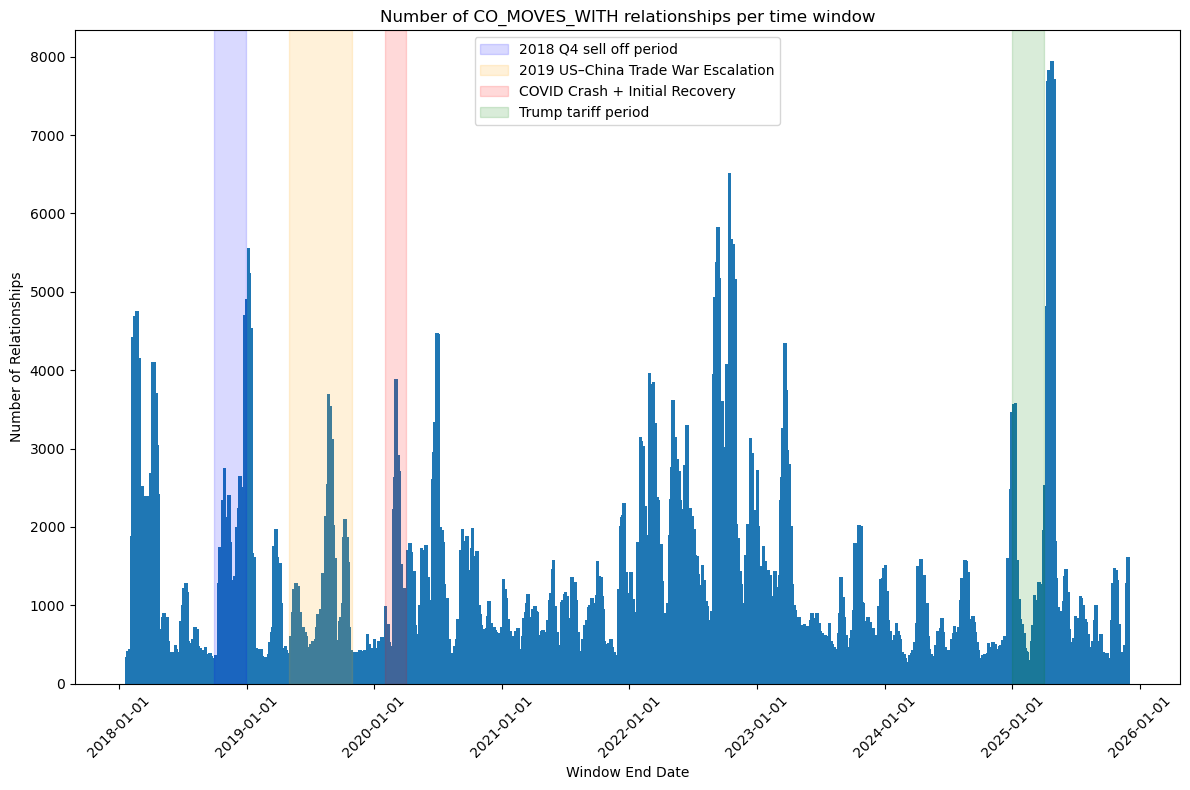

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Copy and convert neo4j.time.Date -> pandas.Timestamp
df_plot = df_windows.copy()
df_plot["end"] = df_plot["end"].apply(
    lambda d: pd.Timestamp(d.year, d.month, d.day)
)

# 2. Create the plot with a datetime x-axis
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(df_plot["end"], df_plot["edges"], width=10)  # width in days (tweak as needed)

# Highlight 2018 Q4 sell off period
selloff_start = pd.Timestamp("2018-10-01")
selloff_end   = pd.Timestamp("2018-12-31")
ax.axvspan(selloff_start, selloff_end, color="blue", alpha=0.15, label="2018 Q4 sell off period")

# Highlight 2019 – US–China Trade War Escalation
tradewar_start = pd.Timestamp("2019-05-01")
tradewar_end   = pd.Timestamp("2019-10-31")
ax.axvspan(tradewar_start, tradewar_end, color="orange", alpha=0.15, label="2019 US–China Trade War Escalation")

# Highlight COVID Crash + Initial Recovery
covid_start = pd.Timestamp("2020-02-01")
covid_end   = pd.Timestamp("2020-04-01")
ax.axvspan(covid_start, covid_end, color="red", alpha=0.15, label="COVID Crash + Initial Recovery")

# Highlight Trump tariff period
trump_start = pd.Timestamp("2025-01-01")
trump_end   = pd.Timestamp("2025-04-01")
ax.axvspan(trump_start, trump_end, color="green", alpha=0.15, label="Trump tariff period")

# Format x-axis nicely
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

ticks = ax.get_xticks()
if len(ticks) > 10:
    ax.set_xticks(ticks[::len(ticks)//10])

ax.set_title("Number of CO_MOVES_WITH relationships per time window")
ax.set_xlabel("Window End Date")
ax.set_ylabel("Number of Relationships")
ax.legend()

plt.tight_layout()
plt.show()


In the graph, windows are identified as `W_<start>_<end>`, where `<start>` and `<end>` are dates in `YYYYMMDD` format.

For example, the last loaded window in the dataset is:

In [6]:
# Grab latest window
latest_window = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       max(r.end) AS end
ORDER BY end DESC
LIMIT 1
""")["window_id"].iloc[0]

latest_window


'W_20251107_20251128'

We can inspect correlations within this window to identify the most strongly correlated stock pairs.

In [26]:
# Top correlated pairs
df_top_pairs = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
RETURN s1.ticker AS src,
       s2.ticker AS dst,
       r.corr    AS corr,
       r.sign    AS sign
ORDER BY abs(r.corr) DESC
""", {"window_id": latest_window})

df_top_pairs.head(5)


,src,dst,corr,sign
0,MPC,VLO,0.938417,POS
1,BLK,URI,0.937265,POS
2,NUE,STLD,0.932521,POS
3,MU,NVDA,0.919985,POS
4,NVDA,WDC,0.919169,POS


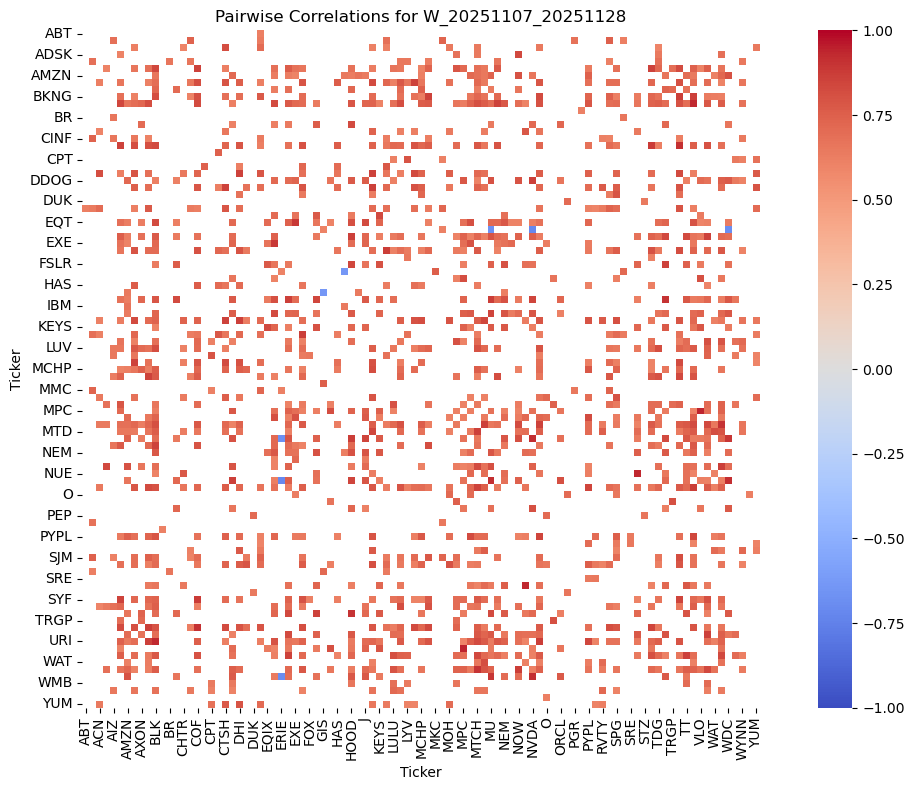

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns

tickers = sorted(set(df_top_pairs["src"]) | set(df_top_pairs["dst"]))
mat = pd.DataFrame(index=tickers, columns=tickers, data=np.nan, dtype=float)

for _, row in df_top_pairs.iterrows():
    s, d, c = row["src"], row["dst"], row["corr"]
    mat.loc[s, d] = c
    mat.loc[d, s] = c   # make symmetric

plt.figure(figsize=(12, 8))
sns.heatmap(
    mat,
    annot=False,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    square=True,
)
plt.title(f"Pairwise Correlations for {latest_window}")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()



We can also investigate how these distributions are spread across different sectors. This can help us understand if certain sectors tend to have stronger internal correlations compared to others. This analysis will likely be a strong signal for our predictive models later on.

In [8]:
# Degree distribution (how connected each stock is)
df_degrees = run_cypher("""
MATCH (s:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-()
RETURN s.ticker AS ticker,
       s.sector AS sector,
       count(r) AS degree
ORDER BY degree DESC
""", {"window_id": latest_window})

df_degrees.head(5)

,ticker,sector,degree
0,BLK,Financial Services,44
1,MTCH,Communication Services,40
2,URI,Industrials,40
3,WDAY,Technology,39
4,NWS,Communication Services,37


## Understanding Connectedness

It will also be important to understand visually how "connected" the market is, we can do this by visually inspecting what the graph looks like for a given time window. Let us visualise the graph for the latest time window in our dataset.

In [10]:
max_edges = 200  # cap to avoid hairballs

df_edges = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
  AND abs(r.corr) >= $threshold
RETURN s1.ticker AS src,
       s2.ticker AS dst,
       r.corr    AS corr
ORDER BY abs(r.corr) DESC
LIMIT $max_edges
""", {
    "window_id": latest_window,
    "threshold": THRESHOLD,
    "max_edges": max_edges
})

df_edges.head()


,src,dst,corr
0,MPC,VLO,0.938417
1,BLK,URI,0.937265
2,NUE,STLD,0.932521
3,MU,NVDA,0.919985
4,NVDA,WDC,0.919169


In [11]:
# Add sector information to nodes
df_nodes = run_cypher("""
MATCH (s:Stock)
RETURN s.ticker AS ticker,
       s.sector AS sector
""")

sector_map = dict(zip(df_nodes["ticker"], df_nodes["sector"]))


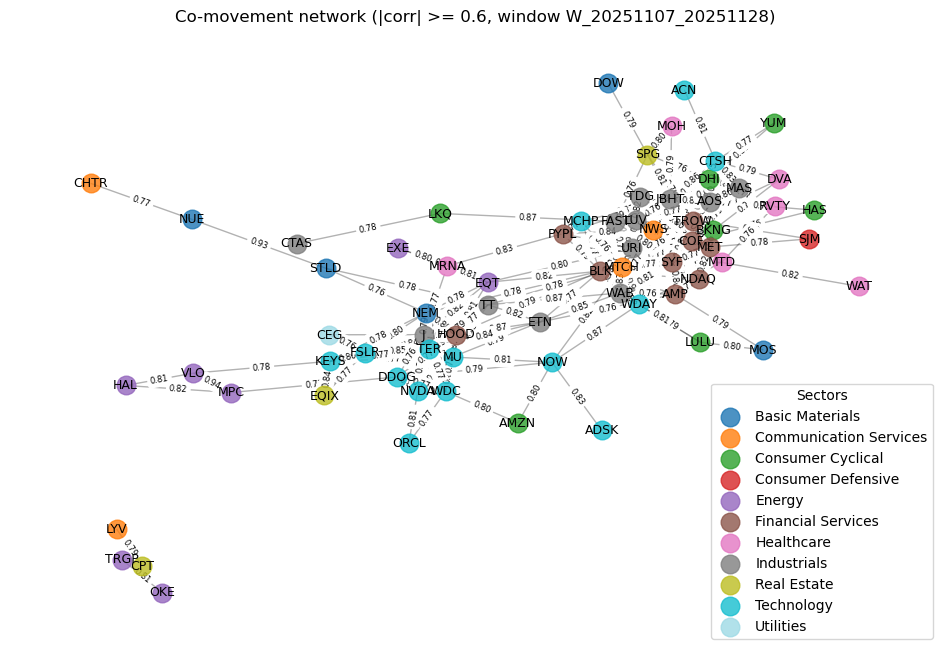

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

G = nx.Graph()

# add edges with corr as weight
for _, row in df_edges.iterrows():
    G.add_edge(row["src"], row["dst"], weight=row["corr"])

# add node attributes (sector)
for node in G.nodes():
    G.nodes[node]["sector"] = sector_map.get(node, "Unknown")

# basic layout
pos = nx.spring_layout(G, k=0.2, iterations=50, seed=42)

plt.figure(figsize=(12, 8))

# Group nodes by sector and draw iteratively ---

# Identify all unique sectors
all_sectors = [G.nodes[n].get("sector", "Unknown") for n in G.nodes()]
unique_sectors = sorted(list(set(all_sectors)))

# Generate a color palette (using tab20 for distinct categorical colors)
color_map = matplotlib.colormaps['tab20'].resampled(len(unique_sectors))

# Loop through sectors and draw specific nodes
for i, sector in enumerate(unique_sectors):
    # Filter nodes belonging to this sector
    nodelist = [n for n in G.nodes() if G.nodes[n].get("sector", "Unknown") == sector]
    
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=180,
        node_color=[color_map(i)], # Assign specific color from map
        label=sector,
        alpha=0.8
    )

nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=9)

# Add labels for correlation values on edges
edge_labels = nx.get_edge_attributes(G, 'weight')
formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_size=6)

# Enable the legend
plt.legend(scatterpoints=1, loc='best', title="Sectors")

plt.title(f"Co-movement network (|corr| >= {THRESHOLD}, window {latest_window})")
plt.axis("off")
plt.show()


It becomes apparent that certain sectors and stocks are more interconnected than others. For example, Industrial stocks are often connected with Financial Services.

In [39]:
# Sector to sector co-movement
df_sector_pairs = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
WITH s1.sector AS sector1,
     s2.sector AS sector2,
     r.corr    AS corr
WHERE sector1 IS NOT NULL AND sector2 IS NOT NULL
RETURN sector1,
       sector2,
       avg(corr) AS avg_corr,
       count(*)  AS edge_count
ORDER BY avg_corr DESC
""", {"window_id": latest_window})

# Sort by edge count descending and avg_corr descending
df_sector_pairs = df_sector_pairs.sort_values(by=["edge_count", "avg_corr"], ascending=[False, False])
df_sector_pairs.head(20)


,sector1,sector2,avg_corr,edge_count
12,Financial Services,Industrials,0.737723,43
7,Financial Services,Financial Services,0.744215,40
5,Technology,Technology,0.752087,38
14,Industrials,Industrials,0.733268,35
52,Technology,Industrials,0.686265,33
21,Industrials,Technology,0.718771,31
23,Industrials,Financial Services,0.715495,26
98,Financial Services,Technology,0.551403,26
66,Industrials,Consumer Cyclical,0.675626,23
26,Financial Services,Consumer Cyclical,0.712121,22


We can visualise this connectedness graphically, where nodes represent sectors and edges represent the average correlation between stocks in those sectors. The thickness of the edges can indicate the strength of the correlation, while the size of the nodes can represent the number of connections (or "strength") of each sector.

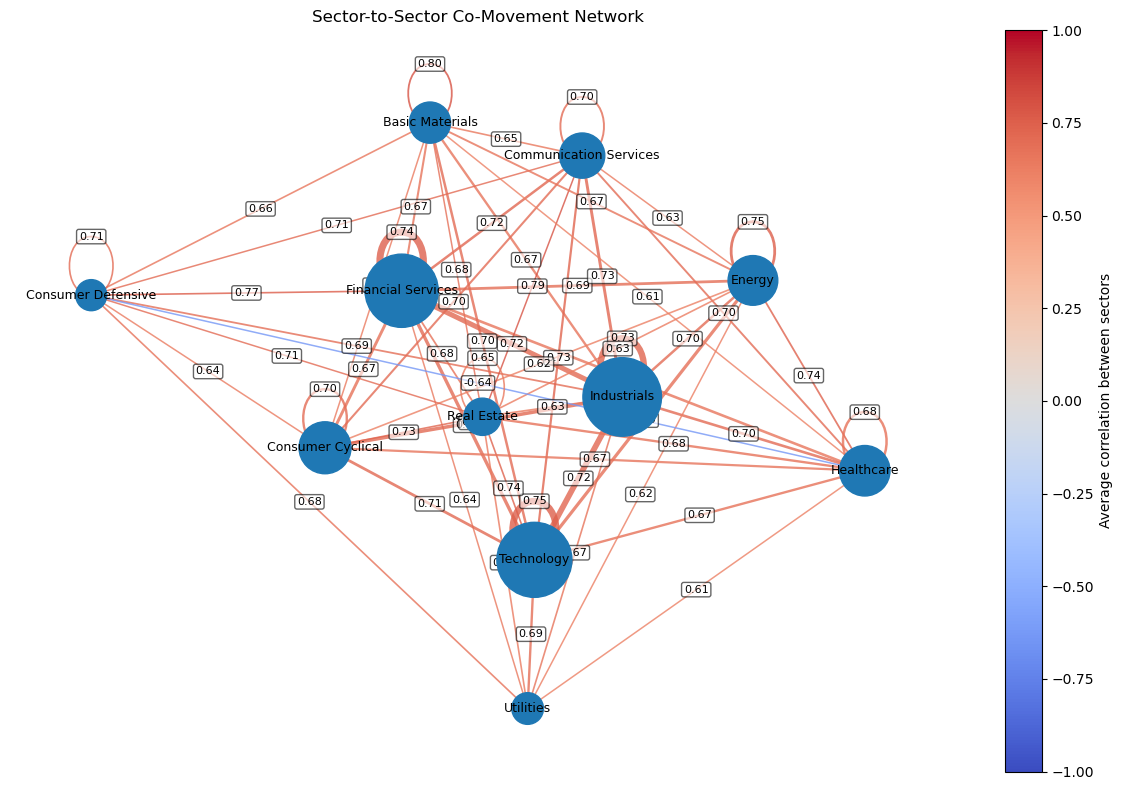

In [46]:
# Filter to strongest / most supported edges to avoid hairball
df_plot = df_sector_pairs.copy()
df_plot = df_plot[df_plot["avg_corr"].abs() >= 0.6]

# Build graph
G = nx.Graph()
for _, row in df_plot.iterrows():
    s1 = row["sector1"]
    s2 = row["sector2"]
    w  = row["avg_corr"]
    c  = row["edge_count"]
    G.add_edge(s1, s2, weight=w, edge_count=c)

# Node size: sum of edge_count touching each sector
sector_strength = {
    node: sum(d["edge_count"] for _, _, d in G.edges(node, data=True))
    for node in G.nodes()
}
node_sizes = [200 + 20 * sector_strength[n] for n in G.nodes()]

# Layout
pos = nx.spring_layout(G, k=0.8, weight="weight", seed=42)

# Edge styling
edges = list(G.edges(data=True))
weights = np.array([e[2]["weight"] for e in edges])
counts  = np.array([e[2]["edge_count"] for e in edges])

cmap = sns.color_palette("coolwarm", as_cmap=True)
norm = plt.Normalize(vmin=-1, vmax=1)  # assuming correlations in [-1, 1]
edge_colors = [cmap(norm(w)) for w in weights]
edge_widths = 1 + 4 * (counts / counts.max())  # thicker = more underlying pairs

fig, ax = plt.subplots(figsize=(12, 8))

# Draw nodes, edges, labels
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, ax=ax)
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.8,
    ax=ax,
)
nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

# Edge labels: round to 2–3 decimals
edge_labels = {
    (u, v): f"{d['weight']:.2f}"
    for u, v, d in G.edges(data=True)
}

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=8,
    rotate=False,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6)
)

# Colorbar for avg_corr
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Average correlation between sectors")

ax.set_title("Sector-to-Sector Co-Movement Network")
ax.axis("off")
plt.tight_layout()
plt.show()

Besides a broad sector-level view, we can also drill down to see which specific stocks are connected for an individual stock, for example, let's look at EQIX in the latest time window.

In [48]:
# Ego network for EQIX
ticker = "EQIX"

df_ego = run_cypher("""
MATCH (s:Stock {ticker: $ticker})-[r:CO_MOVES_WITH {window_id: $window_id}]-(n:Stock)
RETURN n.ticker AS neighbor,
       n.sector AS sector,
       r.corr   AS corr
ORDER BY abs(r.corr) DESC
""", {"ticker": ticker, "window_id": latest_window})

df_ego


,neighbor,sector,corr
0,KEYS,Technology,0.835001
1,FSLR,Technology,0.770334
2,EQT,Energy,0.710815
3,NEM,Basic Materials,0.682711
4,EXE,Energy,0.666331
5,VLO,Energy,0.640590
6,HOOD,Financial Services,0.638669


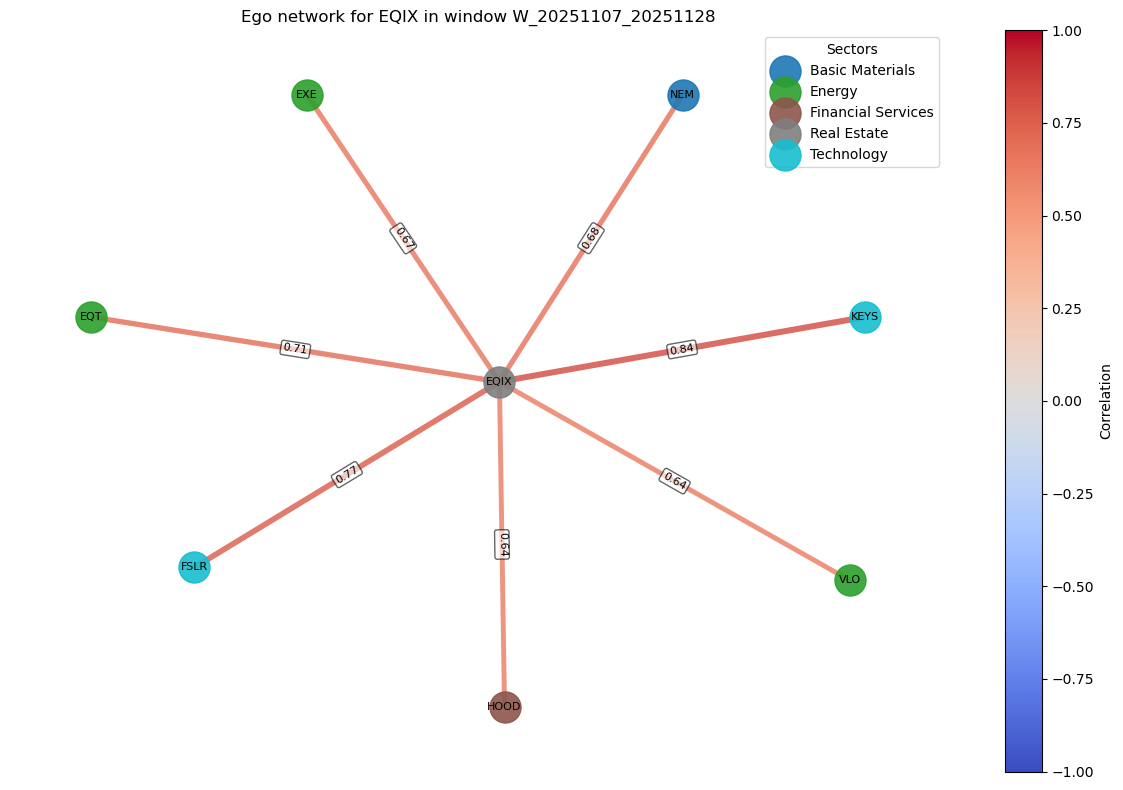

In [49]:
# Build ego graph
G_ego = nx.Graph()
for _, row in df_ego.iterrows():
    G_ego.add_edge(ticker, row["neighbor"], weight=row["corr"])

# Assign sector attributes to nodes
for node in G_ego.nodes():
    G_ego.nodes[node]["sector"] = sector_map.get(node, "Unknown")

pos = nx.spring_layout(G_ego, seed=42)

fig, ax = plt.subplots(figsize=(12, 8))

all_sectors = [G_ego.nodes[n]["sector"] for n in G_ego.nodes()]
unique_sectors = sorted(set(all_sectors))

color_map = matplotlib.colormaps["tab10"].resampled(len(unique_sectors))

for i, sector in enumerate(unique_sectors):
    nodelist = [n for n in G_ego.nodes() if G_ego.nodes[n]["sector"] == sector]
    nx.draw_networkx_nodes(
        G_ego,
        pos,
        nodelist=nodelist,
        node_size=500,
        node_color=[color_map(i)],
        label=sector,
        alpha=0.9,
        ax=ax,
    )

edges = list(G_ego.edges(data=True))
weights = np.array([d["weight"] for _, _, d in edges])  # correlations

cmap = matplotlib.colormaps["coolwarm"]
norm = plt.Normalize(vmin=-1, vmax=1)  # correlation range
edge_colors = [cmap(norm(w)) for w in weights]
edge_widths = 1 + 4 * np.abs(weights)  # thicker for stronger |corr|

nx.draw_networkx_edges(
    G_ego,
    pos,
    edgelist=[(u, v) for u, v, _ in edges],
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.8,
    ax=ax,
)

nx.draw_networkx_labels(G_ego, pos, font_size=8, ax=ax)

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(
    G_ego,
    pos,
    edge_labels=edge_labels,
    font_size=8,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6),
    ax=ax,
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Correlation")

# Legend for sectors
ax.legend(title="Sectors", loc="best")

ax.set_title(f"Ego network for {ticker} in window {latest_window}")
ax.set_axis_off()
plt.tight_layout()
plt.show()